# MNIST Dataset

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

sns.set_theme()

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Loading dataset

In [3]:
(train_ds, test_ds), ds_info = tfds.load(name='mnist', 
                                         split=['train', 'test'],
                                         with_info=True,
                                         as_supervised=True,
                                         shuffle_files=True)

In [4]:
BATCH_SIZE = 64
SHUFFLE_BUFFER = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE

def normalizer(image, label):
    img = tf.cast(image, 'float32') / 255.0
    mean = tf.reduce_mean(img)
    std = tf.math.reduce_std(img)
    return (img - mean) / std, label

train_ds = train_ds.map(normalizer, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_BUFFER)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = test_ds.map(normalizer, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(AUTOTUNE)

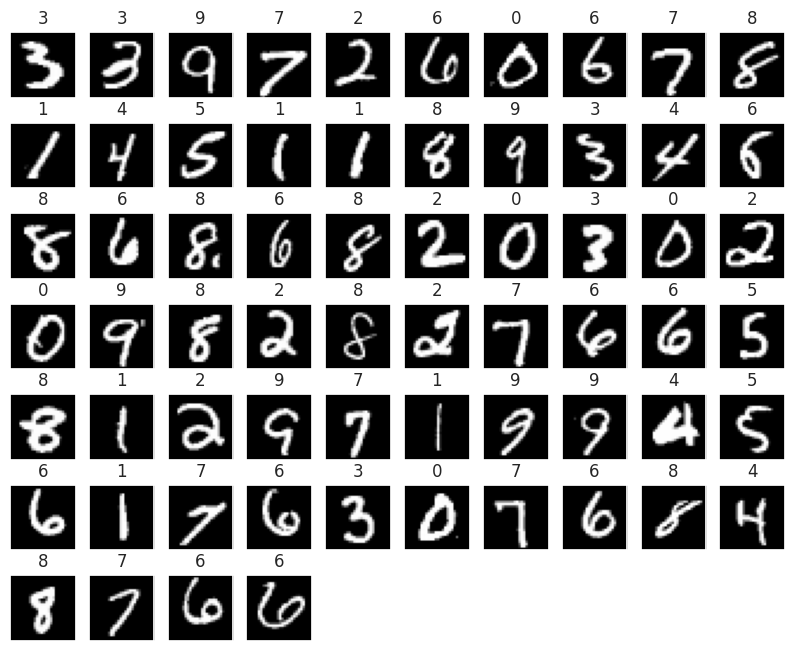

In [5]:
fig = plt.figure(figsize=(10, 10))
preview_data, preview_labels = list(train_ds.take(BATCH_SIZE))[0]

cnt = 0
while True:
    if cnt >= len(preview_labels):
        break
    a = plt.subplot(10, 10, cnt + 1)
    a.tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)
    a.imshow(preview_data[cnt].numpy(), cmap='gray')
    a.set_title(preview_labels[cnt].numpy())
    cnt += 1
    a.grid(False)
fig.subplots_adjust(top=1)

In [6]:
print('Number of Training images {}'.format(ds_info.splits['train'].num_examples))
print('Number of test images {}'.format(ds_info.splits['test'].num_examples))

print(f'Image shape is {preview_data.shape[1:]}')
image_shape = preview_data.shape[1:]

Number of Training images 60000
Number of test images 10000
Image shape is (28, 28, 1)


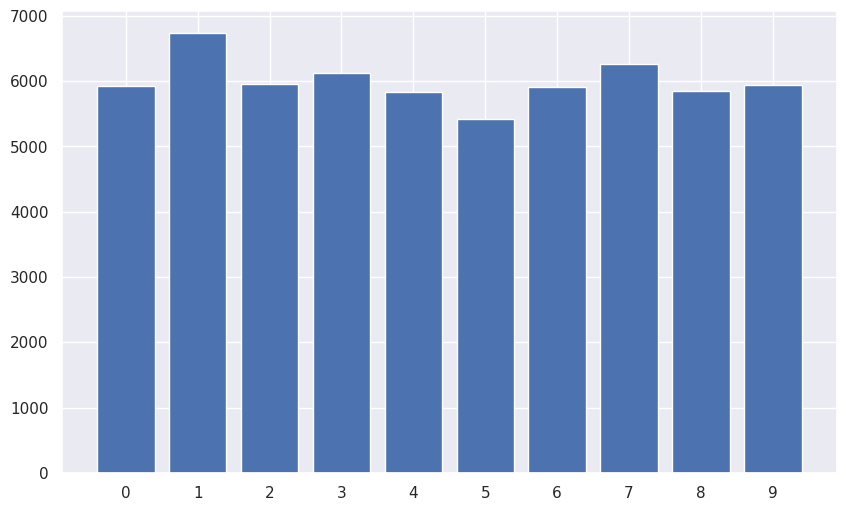

In [7]:
numbers = [0 for _ in range(10)]
for batch in train_ds:
    for nums in batch[-1]:
        numbers[nums] += 1
    
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.bar(range(0, 10), numbers);
ax = plt.gca()
ax.set_xticks([x for x in range(10)]);

## Creating model

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D, Flatten

In [9]:
class ConvBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv2D(filters, kernel_size=kernel_size, padding='same')
        self.batch_normalization = BatchNormalization(axis=-1)
        
    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.batch_normalization(x, training=training)
        x = tf.nn.relu(x)
        return x

In [10]:
class ResBlock(layers.Layer):
    def __init__(self, filters):
        super(ResBlock, self).__init__()
        self.convblock1 = ConvBlock(filters[0])
        self.convblock2 = ConvBlock(filters[1])
        self.convblock3 = ConvBlock(filters[2])
        self.identity_block = Conv2D(filters=filters[1], kernel_size=1, padding='same')
        
    def call(self, input_tensor, training=False):
        x = self.convblock1(input_tensor, training=training)
        x = self.convblock2(x, training=training)
        skip_connection = self.identity_block(input_tensor)
        x = self.convblock3(x + skip_connection, training=training)
        return x

In [11]:
class ResNet(keras.Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv1 = Conv2D(filters=64, kernel_size=7, padding='same')
        self.bn1 = BatchNormalization()
        self.maxpooling = MaxPooling2D(pool_size=(3, 3))
        self.block1 = ResBlock([64, 64, 64])
        self.block2 = ResBlock([64, 64, 64])
        self.block3 = ResBlock([64, 64, 64])
        self.dropout = Dropout(0.2)
        self.classifier = Dense(units=num_classes)
        
    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x, training=training)
        x = keras.layers.Activation('relu')(x)
        x = self.maxpooling(x)
        x = self.block1(x, training=training)
        x = self.block2(x, training=training)
        x = self.block3(x, training=training)
        x = GlobalAveragePooling2D()(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [12]:
def incorrect_prediction(y_true, y_pred):
    return tf.reduce_sum(tf.cast(tf.not_equal(y_pred, y_true), 'int64'))

In [13]:
class F1_Score(tf.keras.metrics.Metric):
    '''
    True Positive (TP): The number of instances that were correctly classified as positive.
    False Positive (FP): The number of instances that were incorrectly classified as positive.
    True Negative (TN): The number of instances that were correctly classified as negative.
    False Negative (FN): The number of instances that were incorrectly classified as negative.
    
    Precision is the fraction of positive instances that were correctly classified. It is calculated as follows:
    Precision = TP / (TP + FP)
    
    Recall is the fraction of all positive instances that were correctly classified. It is calculated as follows:
    Recall = TP / (TP + FN)
    
    The F1 score is a measure of a model's accuracy that takes into account both the precision and recall of the model. It is calculated as follows:
    F1 = 2 * (precision * recall) / (precision + recall)
    
    where:
    Precision is the fraction of positive instances that were correctly classified.
    Recall is the fraction of all positive instances that were correctly classified.
    '''
    def __init__(self, name='f1_score', **kwargs):
        super(F1_Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)
            
    def result(self):
        self.f1.assign(2 * (self.precision.result() * self.recall.result()) / (self.precision.result() + self.recall.result() + tf.keras.backend.epsilon()))
        return self.f1
    
    
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [14]:
model = ResNet(10)
model.build([None, 28, 28, 1])
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.RMSprop()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', F1_Score()])

In [15]:
model.summary()

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 res_block (ResBlock)        multiple                  115712    
                                                                 
 res_block_1 (ResBlock)      multiple                  115712    
                                                                 
 res_block_2 (ResBlock)      multiple                  1157

In [16]:
history = model.fit(train_ds, validation_data=test_ds, epochs=6)

Epoch 1/6
938/938 [==============================] - 16s 9ms/step - loss: 0.1446 - accuracy: 0.9617 - f1_score: 0.9973 - val_loss: 0.9671 - val_accuracy: 0.8295 - val_f1_score: 0.9510
Epoch 2/6
938/938 [==============================] - 8s 9ms/step - loss: 0.0503 - accuracy: 0.9853 - f1_score: 0.9990 - val_loss: 0.0885 - val_accuracy: 0.9742 - val_f1_score: 0.9928
Epoch 3/6
938/938 [==============================] - 8s 9ms/step - loss: 0.0361 - accuracy: 0.9891 - f1_score: 0.9993 - val_loss: 0.0469 - val_accuracy: 0.9862 - val_f1_score: 0.9995
Epoch 4/6
938/938 [==============================] - 9s 9ms/step - loss: 0.0304 - accuracy: 0.9910 - f1_score: 0.9995 - val_loss: 0.0795 - val_accuracy: 0.9737 - val_f1_score: 0.9991
Epoch 5/6
938/938 [==============================] - 8s 9ms/step - loss: 0.0248 - accuracy: 0.9929 - f1_score: 0.9996 - val_loss: 0.0319 - val_accuracy: 0.9903 - val_f1_score: 0.9994
Epoch 6/6
938/938 [==============================] - 8s 8ms/step - loss: 0.0220 - ac

## Model Evaluation

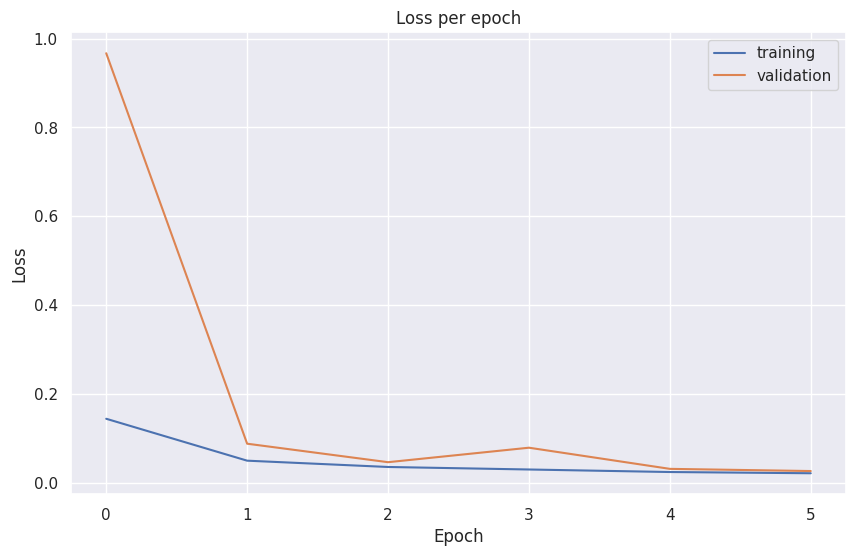

In [17]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(history.epoch, history.history['loss'], label='training')
plt.plot(history.epoch, history.history['val_loss'], label='validation')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss');
plt.legend();

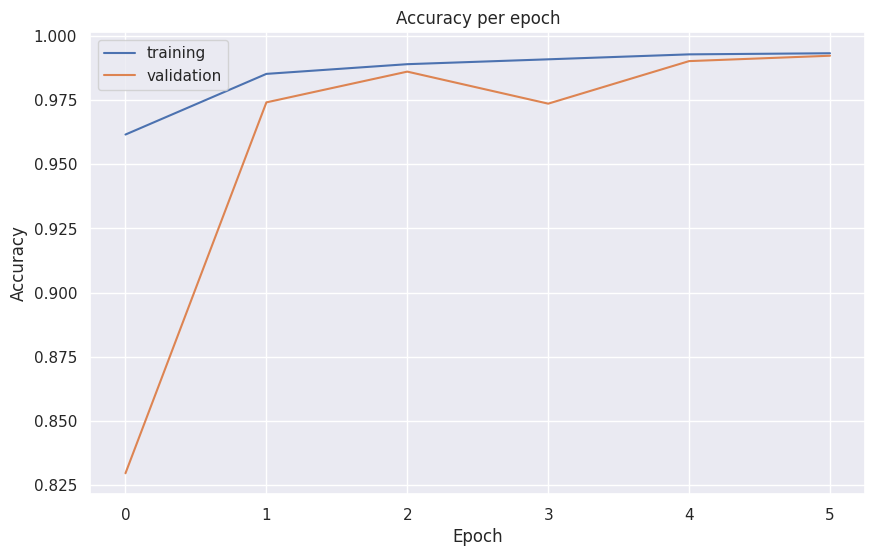

In [18]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(history.epoch, history.history['accuracy'], label='training')
plt.plot(history.epoch, history.history['val_accuracy'], label='validation')
plt.title('Accuracy per epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy');
plt.legend();

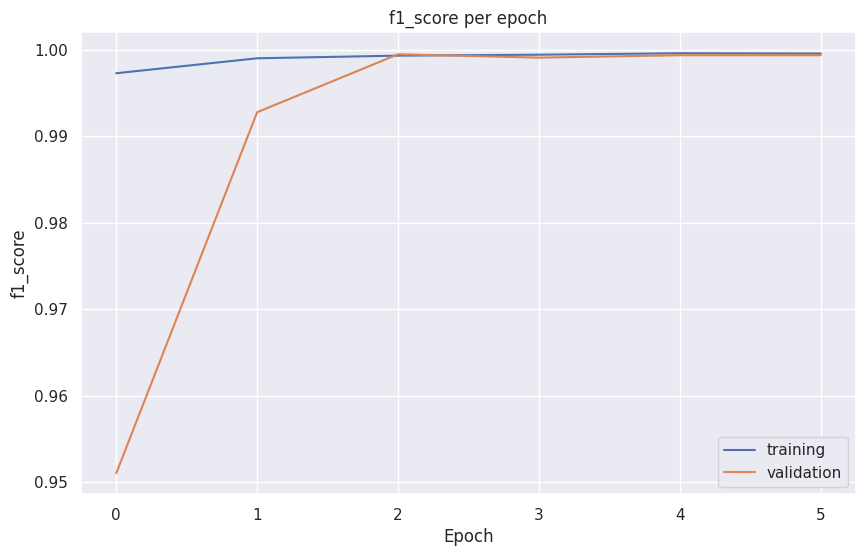

In [19]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(history.epoch, history.history['f1_score'], label='training')
plt.plot(history.epoch, history.history['val_f1_score'], label='validation')
plt.title('f1_score per epoch')
plt.xlabel('Epoch')
plt.ylabel('f1_score');
plt.legend();

157/157 [==============================] - 1s 2ms/step


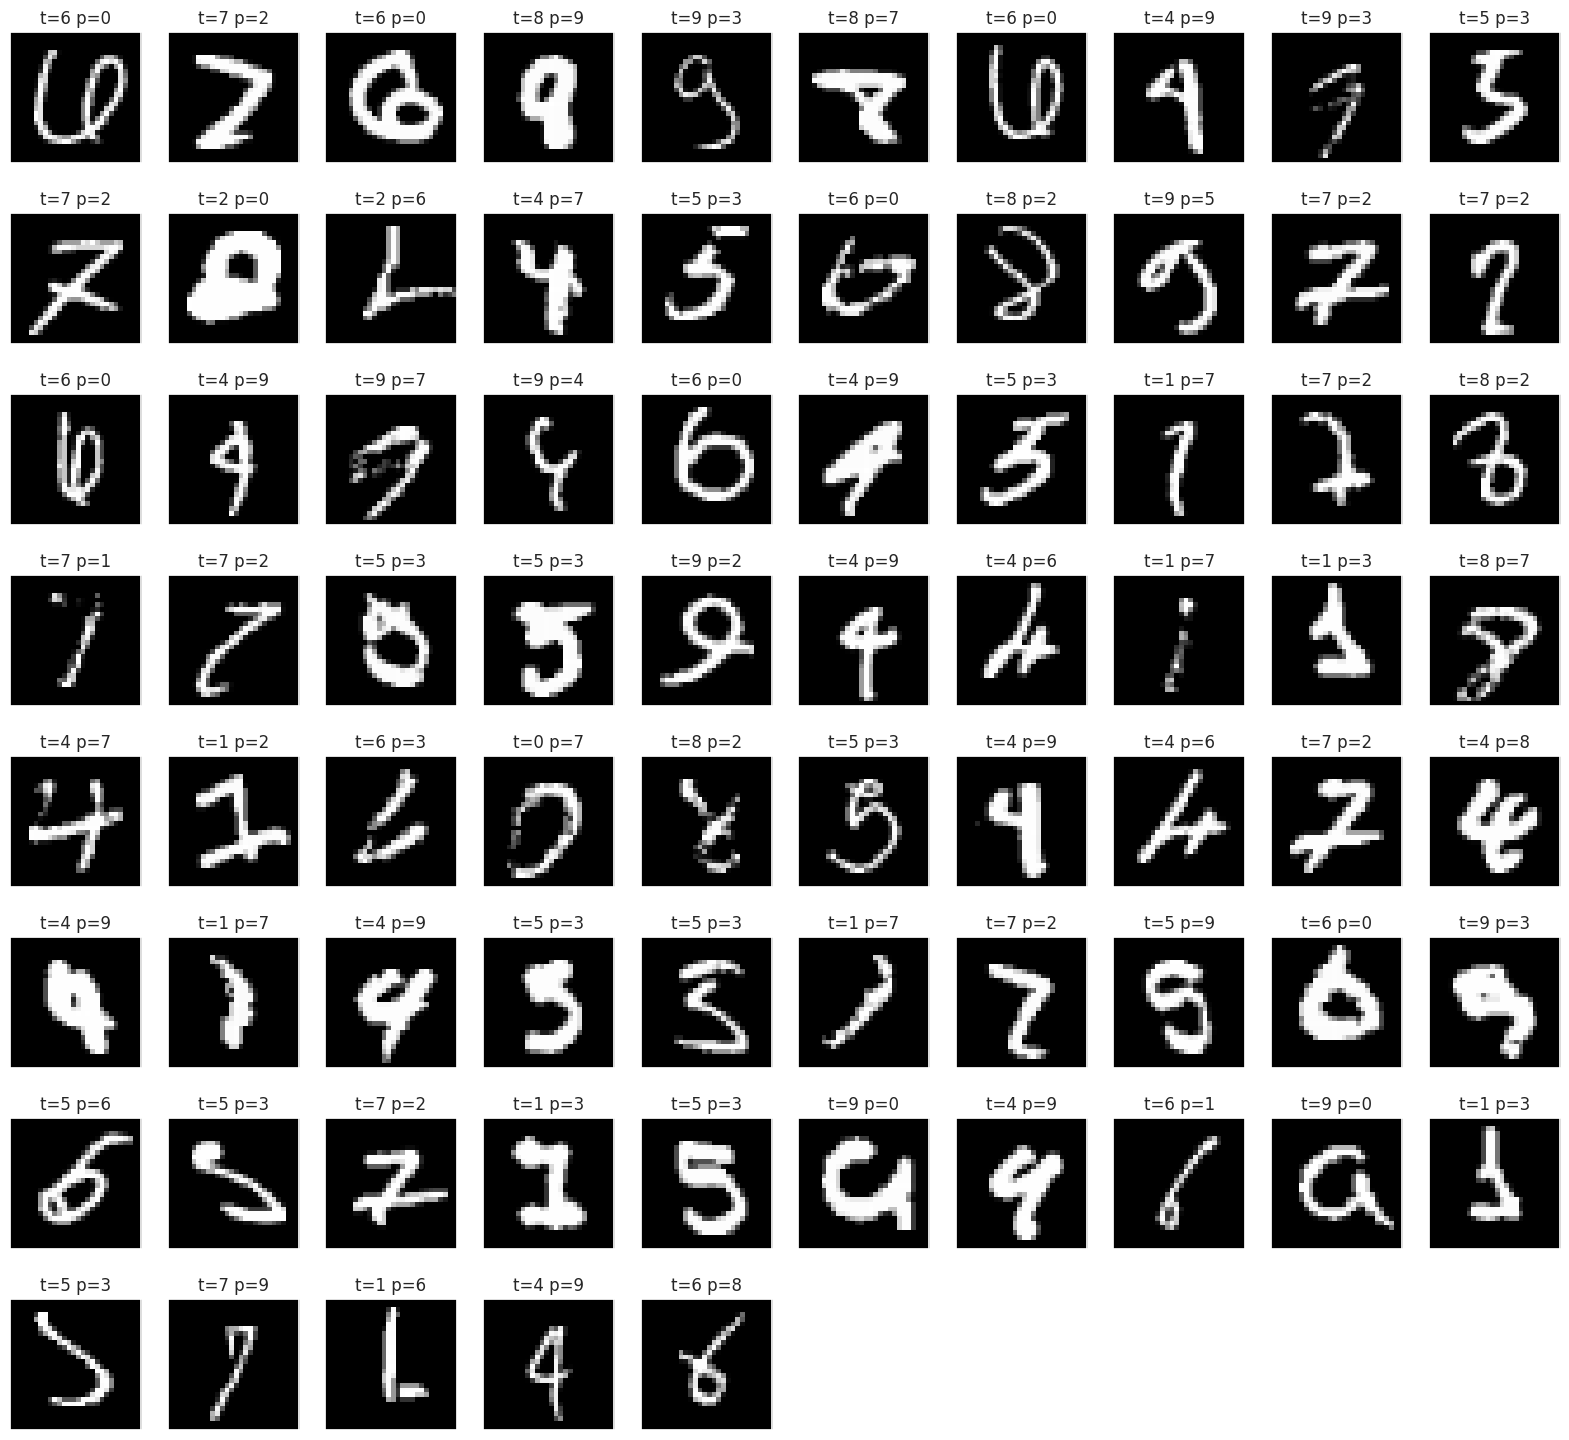

In [20]:
activations = tf.nn.softmax(model.predict(test_ds))
y_hat = tf.argmax(activations, axis=-1)
y_true = np.concatenate([x[-1].numpy() for x in test_ds])

labels = []
images = []
cnt = 0
for x in test_ds:
    for i in range(len(x[0])):
        if x[-1][i] != y_hat[cnt]:
            labels.append((x[-1][i], y_hat[cnt]))
            images.append(x[0][i])
        cnt += 1


fig = plt.figure(figsize=(20, 20))
for cnt in range(1, 101):
    if cnt >= len(labels):
        break
    ax = plt.subplot(10, 10, cnt)
    ax.tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)
    ax.imshow(images[cnt - 1], cmap='gray')
    ax.set_title(f't={labels[cnt - 1][0]} p={labels[cnt - 1][1]}')
    ax.grid(False)
    cnt += 1
fig.subplots_adjust(top=1)

del images
del labels

157/157 [==============================] - 1s 4ms/step


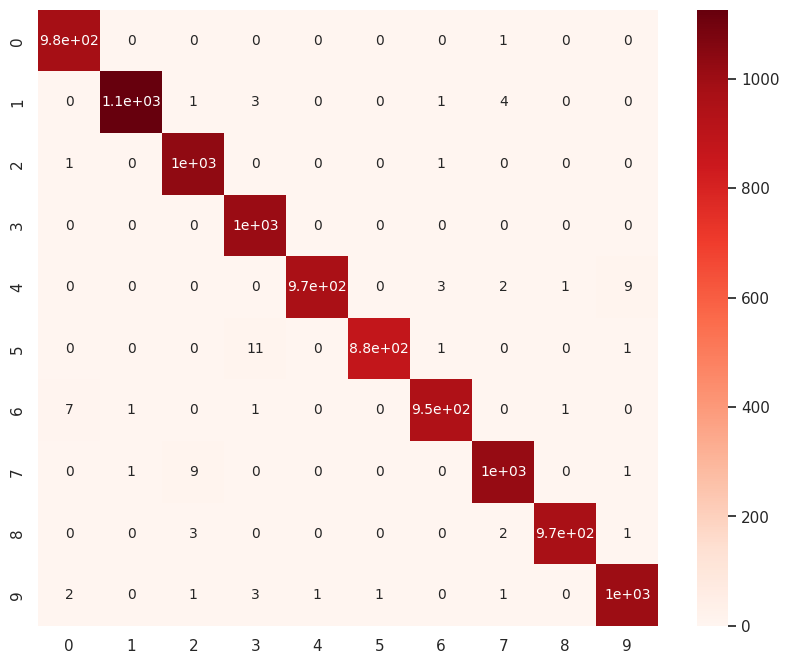

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

activations = tf.nn.softmax(model.predict(test_ds))
y_hat = tf.argmax(activations, axis=-1)
y_true = np.concatenate([x[-1].numpy() for x in test_ds])
cm = confusion_matrix(y_true, y_hat)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm, annot=True, xticklabels=[x for x in range(10)], yticklabels=[x for x in range(10)],
                annot_kws={"size": 10}, cmap='Reds')

In [22]:
activations = tf.nn.softmax(model.predict(test_ds))
y_hat = tf.argmax(activations, axis=-1)
y_true = np.concatenate([x[-1].numpy() for x in test_ds])
print(f"There are {incorrect_prediction(y_true, y_hat)} incorrect predictions in test")

157/157 [==============================] - 0s 2ms/step
There are 76 incorrect predictions in test


In [23]:
activations = tf.nn.softmax(model.predict(test_ds))
y_hat = tf.argmax(activations, axis=-1)
y_true = np.concatenate([x[-1].numpy() for x in test_ds])
report = classification_report(y_true, y_hat)
print(report)

157/157 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.98      1.00      0.99      1010
           4       1.00      0.98      0.99       982
           5       1.00      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

